In [1]:
import random
import pandas as pd
import scanpy as sc
import numpy as np
from nanoTxformer.tokenizer import scTokenizer
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from sklearn.random_projection import GaussianRandomProjection

from latentmi import lmi
from matplotlib import rcParams
from tqdm.notebook import tqdm

/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def counts_to_ranks(ad):
    tk = scTokenizer(ad)
    n_ad = tk.normalize_with_stored_medians(ad)
    return np.apply_along_axis(rankdata, 1, n_ad.X)

In [3]:
qualities = np.logspace(-3, 0, 10)[::-2]
r = 0
representation_dims = [16]#[8, 32, 128, 512]
n_proj = 1

In [4]:
d = {
    "UMI per cell" : [],
    "Encoding" : [],
    "Representation dim." : [],
    "MI" : []
}

for qual in tqdm(qualities):

    # load and preprocess
    ad = sc.read_h5ad('../../scaling_playground/data/PBMC_CITEseq_Q%.3f_rep%d.h5ad'
                  %(qual, r))
    sc.pp.subsample(ad, n_obs=5*10**4)
    n_ad = counts_to_ranks(ad)

    for rep_dim in representation_dims:

        for _ in range(n_proj):
            # count embedding
            rand_proj = GaussianRandomProjection(n_components=rep_dim)
            emb = rand_proj.fit_transform(np.asarray(ad.X.todense()))
            pmis, _, _ = lmi.estimate(emb, ad.obsm['protein_counts'], 
                                quiet=True, batch_size=2048)
        
            d['UMI per cell'].append(ad.raw.X.sum()/len(ad))
            d['Encoding'].append('count')
            d['MI'].append(np.nanmean(pmis))
            d["Representation dim."].append(rep_dim)
        
            rand_proj = GaussianRandomProjection(n_components=rep_dim)
            emb = rand_proj.fit_transform(np.asarray(n_ad))
            pmis, _, _ = lmi.estimate(emb, ad.obsm['protein_counts'], 
                                quiet=True, batch_size=2048)
        
            d['UMI per cell'].append(ad.raw.X.sum()/len(ad))
            d['Encoding'].append('rank')
            d['MI'].append(np.nanmean(pmis))
            d["Representation dim."].append(rep_dim)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 197 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻

In [5]:
df = pd.DataFrame(d)
sns.set_style('whitegrid')
rcParams['figure.dpi'] = 150

/tmp/ipykernel_572248/1996189551.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.lineplot(df, x='UMI per cell', y='MI', style='Encoding', marker='o', palette='tab10')


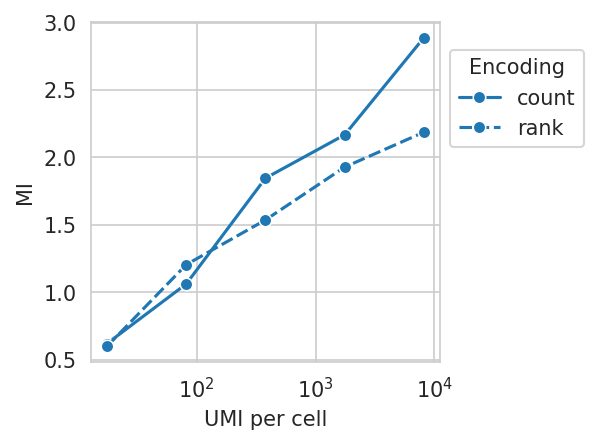

In [11]:
from matplotlib import rcParams
rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = (3,3)

g = sns.lineplot(df, x='UMI per cell', y='MI', style='Encoding', marker='o', palette='tab10')
plt.xscale('log')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 0.95))
plt.show()

In [8]:
df.to_csv('../results/rank_encoding_info_loss.csv')

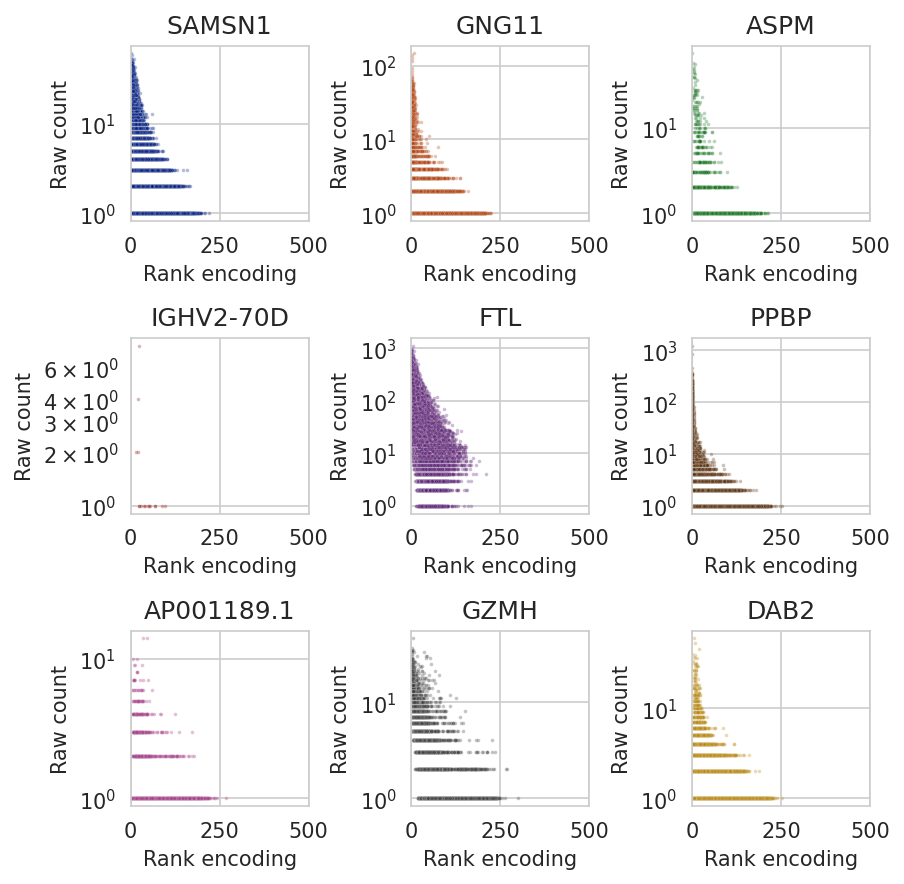

In [12]:
adata = sc.read_h5ad("../../scaling_playground/data/PBMC_CITEseq_Q1.000_rep0.h5ad")
tk = scTokenizer(adata)
n_adata = tk.normalize_with_stored_medians(adata)

# Generate random gene indices
random_gene_indices = random.sample(range(adata.n_vars), 9)

# Prepare a color palette with 9 distinct colors
colors = sns.color_palette('dark', 9)

# sns.set_style('whitegrid')

# Set up a 3x3 grid for the plots
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
fig.subplots_adjust(hspace=0.4)
axes = axes.flatten()

for idx, gene_index in enumerate(random_gene_indices):
    gene_name = adata.var_names[gene_index]
    ranks = []
    
    # Calculate the rank encoding for each cell
    for cell in range(len(adata)):
        cell_expression = n_adata.X[cell, :]
        sorted_gene_indices = np.argsort(-cell_expression)
        ranks.append(np.where(sorted_gene_indices == gene_index)[0][0])

    # Plot the data in the corresponding subplot
    ax = axes[idx]
    sns.scatterplot(
        x=ranks, 
        y=np.array(adata.layers["counts"][:, gene_index].todense().flatten())[0], 
        s=3, alpha=0.3, 
        ax=ax, 
        color=colors[idx]
    )
    
    ax.set_xlabel('Rank encoding')
    ax.set_ylabel('Raw count')
    ax.set_xlim(0, 500)
    ax.set_yscale('log')
    ax.set_title(gene_name)

# Set the DPI of the figure
plt.gcf().set_dpi(150)
plt.tight_layout()
plt.show()